In [2]:
import os
import datetime

import numpy as np 
import gymnasium as gym
import ale_py


try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    SummaryWriter = None  # type: ignore[misc, assignment]

gym.register_envs(ale_py)

env = gym.make('PongDeterministic-v4')
observation, info = env.reset()
print(observation.shape)

(210, 160, 3)


In [3]:
# hyperparameters
ENV_NUM = 4
GAMMA = 0.99 # discount factor for reward
DECAY_RATE = 0.99  # decay factor for RMSProp leaky sum of grad^2
LR = 3e-4 # learning rate
EPSILON = 1e-8 #epsilon in RMSProp formula
ENTROPY = 0.01
MAX_STEPS=4096

ALGO="adam"
SAVE_PATH = f"./models/checkpoint-pong_conv_parallel_4096_{ALGO}.pth"
RENDER = False
RESUME = False # resume from previous checkpoint?

## Define Model, Optimizer, Loss with Torch

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Prioritize device: CUDA > MPS > CPU
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("CUDA is available. Using CUDA.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("MPS backend is available. Using MPS.")
else:
    DEVICE = torch.device("cpu")
    print("Neither CUDA nor MPS is available. Using CPU.")

# It works better on CPU, then on MPS, keep this way

class Model(nn.Module):

    def __init__(self, filters_multiplier = 1):
        """Initialize parameters and build model.
        Params
        ======
            img_size (int): Dimension of each state
            hidden_layer_neurons (int): Number of hidden neurons 
        """
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(1, 16*filters_multiplier, kernel_size=8, stride=4) # 19x19x16 / params 8*8*1*16 = 1024
        # (80+2*0-8)/4 + 1 = 19

        self.conv2 = nn.Conv2d(16*filters_multiplier, 32*filters_multiplier, kernel_size=5, stride=2) # 8*8*32 / params 5*5*16*32 = 12800
        # (19 +2*0-5)/2 + 1 = 8
        self.size=8*8*32*filters_multiplier


        # 2 fully connected layers
        self.fc1 = nn.Linear(self.size, 200) #8*8*32*200 = 409600
        self.fc2 = nn.Linear(200, 1) # 200*1 = 200
    
    def forward(self, state):
        """Build a network that maps state -> probability action up."""
        x = F.relu(self.conv1(state))
        x = F.relu(self.conv2(x))
        
        x = x.view(-1, self.size)
        x = F.relu(self.fc1(x))
        
        output = F.sigmoid(self.fc2(x))
        return output

#improvement suggestion 
# 1st layer 32 filters /8*8*1*32=2048
# 2nd layer 64 filters/ 5*5*32*64=51200 
# fc layers 8*8*64*200 = 819200 + 200
model = Model(filters_multiplier=2)

model.to(DEVICE)
if ALGO == "rmsprop":
    # we updated parameters 2nd time LR to 0.001 from 0.0001, EPSILON to  1e-8 from 1e-5 and alpha stays same, we don't have momentum like adam though
    optimizer = optim.RMSprop(model.parameters(), lr=LR, eps=EPSILON, alpha=DECAY_RATE)
else: 
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

MPS backend is available. Using MPS.


## Image PreProcessing 

In [5]:
def preprocess(image):
    """ Pre-process 210x160x3 uint8 frame into 6400 (80x80) 1D float vector. """
    image = torch.Tensor(image).to(DEVICE) #converts to float 
    
    # Crop, downsample by factor of 2, and turn to grayscale by keeping only red channel
    image = image[35:195]
    image = image[::2,::2, 0]

    image[image == 144] = 0 # erase background (background type 1)
    image[image == 109] = 0 # erase background (background type 2)
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1

    return image.unsqueeze(0).float() # (1,80,80)

def batch_preprocess(images):
    """ Pre-process 210x160x3 uint8 frame into 6400 (80x80) 1D float vector. """
    images = torch.Tensor(images).to(DEVICE) #converts to float 
    
    # Crop, downsample by factor of 2, and turn to grayscale by keeping only red channel
    images = images[:, 35:195, :, :]
    images = images[:, ::2,::2, 0]

    # erase background (background type 1) and # erase background (background type 2)
    images = torch.where((images == 144) | (images == 109), torch.tensor(0.0, device=DEVICE), images)

    images = (images != 0).float()# everything else (paddles, ball) just set to 1

    return images.unsqueeze(1)

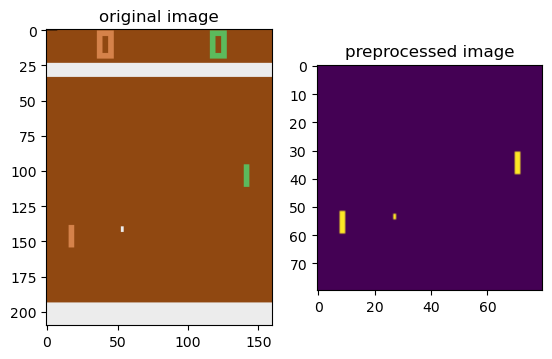

In [13]:
import matplotlib
import matplotlib.pyplot as plt

env.reset()
_, _, _, _, _= env.step(0)
# get a frame after 20 steps - that's about the number needed to see the full screen with gameplay
for _ in range(20):
    frame, _, _, _, _ = env.step(0)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.imshow(preprocess(frame).squeeze(0).cpu())
plt.title('preprocessed image')
plt.show()

## Train

In reinforcement learning (RL), the term surrogate function is used because the error function or objective function we optimize in many RL algorithms is not the direct objective we want to maximize (e.g., the true return 
  or long-term reward). Instead, we use a proxy or surrogate objective that is easier to compute, differentiate, or optimize. The surrogate serves as a stand-in that approximates or facilitates learning toward the true objectiv

In [ ]:
def collect_trajectories(envs, model, max_steps=1024):
    
    num_envs = envs.num_envs
    action_chosen_prob_list, state_list, action_list, reward_list = [], [], [], []
    obs, _ = envs.reset()

    prev_processed_obs = batch_preprocess(obs)
    UP = torch.tensor(2, dtype=torch.int8, device=DEVICE)
    DOWN = torch.tensor(3, dtype=torch.int8, device=DEVICE)
    envs_finished_early =  []

    for t in range(max_steps):
        processed_obs = batch_preprocess(obs)
        states = processed_obs - prev_processed_obs
        prev_processed_obs = processed_obs

        # calculate probability of taking action up
        up_probs = model(states).squeeze(1)
        
        actions =  torch.where(torch.rand(num_envs, device=DEVICE) < up_probs, UP, DOWN) # toss the coin, up or down 
        action_chosen_probs = torch.where(actions == UP,  up_probs,  (1 - up_probs))

        # carry out the chosen action
        obs, rewards, terminated, truncated, _ = envs.step(actions)
        
        # collect all the data
        reward_list.append(rewards)
        action_list.append(actions)
        state_list.append(states)
        action_chosen_prob_list.append(action_chosen_probs) 

        # stop if any of the trajectories is done
        # we want all the lists to be rectangular
        # from further review of the implementation, it apperently will continue 
        # if one of episodes ends, it resets and continues until all steps done
        # we will use same methodic, because stable baselines do too.
        # done = terminated | truncated
        # if done.any():
        #     done_indices = np.nonzero(done)[0] 
        #     envs_finished_early.append(done_indices)
        # #  break
    
    action_list = torch.stack(action_list)
    state_list = torch.stack(state_list)
    reward_list = torch.tensor(np.array(reward_list), dtype=torch.float32, device=DEVICE)
    action_chosen_prob_list = torch.stack(action_chosen_prob_list)
    # print('LOG: Terminated early envs:', envs_finished_early)
   
    return action_chosen_prob_list, state_list, action_list, reward_list

def future_discounted_rewards(rewards, gamma):
    """ Actions you took x steps before the end result are less important to the overall result than an action you took a step ago.
    This implements that logic by discounting the reward on previous actions based on how long ago they were taken
        discounted_future_reward[t] = \sum_{k=1} discount_factor^k * reward[t+k]"""

    T, n_envs = rewards.shape

    future_rewards = torch.empty_like(rewards, device=DEVICE)
    running_add = torch.zeros(n_envs, device=DEVICE)
    # Compute discounted_future_reward for each timestep by iterating backwards
    # from end of episode to beginning
    for t in  range(T - 1, -1, -1):
        # Reset running_add where rewards[t] != 0 (e.g., at episode boundaries)
        mask = (rewards[t] != 0)
        running_add[mask] = 0  # If rewards[t] != 0, we are at game boundary (win or loss) so we
            # reset discounted_future_reward to 0 (this is pong specific!)
        
        running_add = running_add * gamma + rewards[t]
        future_rewards[t] = running_add

    return future_rewards


def surrogate(model, action_probs, states, actions, rewards,
               discount=0.99, beta=0.01):
    
    # lets use simple calculation of rewards here
    # discounts = discount**torch.arange(len(rewards), device=DEVICE) # (step size)
    # discounted_rewards = rewards*discounts.unsqueeze(1) #broadcasting applied (steps, envs)* (steps, 1)
    # #lets now calculate future rewards
    # future_rewards = discounted_rewards.flip(dims=[0]).cumsum(dim=0).flip(dims=[0])
    # # per step normalization
    # mean = future_rewards.mean(dim=1, keepdim=True)  # Mean for each step (across environments). (steps,1)
    # std = future_rewards.std(dim=1, keepdim=True) + 1.0e-10  # Std for each step (across environments). (steps,1)
    # rewards_normalized = (future_rewards - mean) / std

    future_rewards = future_discounted_rewards(rewards, discount)
    # per eipsode normalization
    mean = future_rewards.mean(dim=0, keepdim=True)  # Mean for each epsiode (across environments). (1,envs)
    std = future_rewards.std(dim=0, keepdim=True) + 1.0e-10  # Std for each episode (across environments). (1,envs)
    rewards_normalized = (future_rewards - mean) / std

    # include a regularization term
    # this steers new_policy towards 0.5
    # which prevents policy to become exactly 0 or 1
    # this helps with exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(action_probs * torch.log(action_probs + 1e-10) +
        (1.0-action_probs)*torch.log(1.0-action_probs+1e-10))  # lets add entropy
    
    # print(action_probs.shape)
    # print(entropy.shape)
    # print(rewards_normalized.shape)
    
    return torch.mean(rewards_normalized*torch.log(action_probs) + beta*entropy)

def train(model, envs, start_time, last_episode, tf_writer, max_steps=1024, n_episodes=10000):
    i_episode = last_episode + 1
    entropy_coefficient = 0.0
    if ENTROPY:
        initial_entropy_coeff = ENTROPY
        final_entropy_coeff = 0.001
        diff_coeff = initial_entropy_coeff - final_entropy_coeff
        total_episodes = 500  # episodes before getting to 0.001

    done = False
    while not done:

        if ENTROPY:
            progress = min(i_episode / total_episodes, 1.0)  # Ensure it's capped at 1.0
            entropy_coefficient = initial_entropy_coeff - progress * (diff_coeff)
        
        # collect trajectories -> first step
        action_probs, states, actions, rewards = \
            collect_trajectories(envs, model, max_steps)
        
        total_rewards = rewards.sum(dim=0) # sum by columns 

        L = -surrogate(model, action_probs, states, actions, rewards, beta=entropy_coefficient)

        optimizer.zero_grad()
        L.backward()
        optimizer.step()

        # get the average reward of the parallel environments
        mean_rewards = np.mean(total_rewards.cpu().numpy())

        # Batch metrics and tensorboard logging
        print(f'Batch: {i_episode}, mean loss: {L :.4f}, '
              f'mean reward: {mean_rewards:.2f}')
        print(total_rewards)
        tf_writer.add_scalar('mean loss', L.detach().item(), i_episode)
        tf_writer.add_scalar('mean reward', mean_rewards, i_episode)

        if i_episode % 10 == 0: 
            print('Saving checkpoint...')
            save_dict = {
                'model_weights': model.state_dict(),
                'start_time': start_time,
                'last_batch': i_episode
            }
            torch.save(save_dict, SAVE_PATH)
        
        if i_episode >= n_episodes:
            done = True
        
        i_episode += 1

In [17]:
envs = gym.make_vec('PongDeterministic-v4', num_envs=ENV_NUM, vectorization_mode="sync")

# Set up tensorboard logging
if RESUME: 
    print('Loading from checkpoint...')
    save_dict = torch.load(SAVE_PATH)

    model.load_state_dict(save_dict['model_weights'])
    start_time = save_dict['start_time']
    last_batch = save_dict['last_batch']
else:
    start_time = datetime.datetime.now().strftime("%H.%M.%S-%m.%d.%Y")
    last_batch = -1

tf_writer = SummaryWriter(os.path.join('runs', start_time + f'-CONV-PARALLEL-4096-{ALGO}'))

#NOTE: Indeed we learned that to make total winning strategy for the agent we need more then 2048 steps,
# then it able not onluy protect but all beat the ass off the game robot
# from what logically I see in parallel env, people like to increase slowly the number of steps, but I feel like 
# why not let it play fully from start....
# feels like tbh when we run parallel envs best is do increases, learn 256/512, then learn 1024/2048 and in the end may be 4096 to beat 
# this way agent learns to generalize early on smaller steps and then adjusts with each time traejctory increase. That's my envision from current
# training results, even those when we start froms tart 4096, it gets to 13 points and gets tired there, while we need to get to 24+
train(model, envs, start_time, last_batch, tf_writer, max_steps=MAX_STEPS, n_episodes=1000)  

Batch: 0, mean loss: -0.0069, mean reward: -83.25
tensor([-79., -76., -83., -95.], device='mps:0')
Saving checkpoint...
Batch: 1, mean loss: -0.0063, mean reward: -92.75
tensor([-96., -90., -91., -94.], device='mps:0')
Batch: 2, mean loss: -0.0069, mean reward: -77.50
tensor([-78., -76., -78., -78.], device='mps:0')
Batch: 3, mean loss: -0.0070, mean reward: -80.75
tensor([-80., -77., -80., -86.], device='mps:0')
Batch: 4, mean loss: -0.0068, mean reward: -74.00
tensor([-83., -77., -71., -65.], device='mps:0')
Batch: 5, mean loss: -0.0073, mean reward: -84.50
tensor([-81., -88., -81., -88.], device='mps:0')
Batch: 6, mean loss: -0.0069, mean reward: -77.75
tensor([-76., -73., -88., -74.], device='mps:0')
Batch: 7, mean loss: -0.0073, mean reward: -81.25
tensor([-77., -84., -90., -74.], device='mps:0')
Batch: 8, mean loss: -0.0070, mean reward: -84.00
tensor([-94., -76., -75., -91.], device='mps:0')
Batch: 9, mean loss: -0.0071, mean reward: -80.50
tensor([-76., -89., -75., -82.], devic

### Review video result

In [18]:
import os
import imageio
import numpy as np
from IPython.display import Video, display, HTML

def record_video(env, policy, out_directory, out_name, fps=60):
    """
    Generate a replay video of the agent and display it in the notebook.
    :param env: Environment to record.
    :param policy: Policy used to determine actions.
    :param out_directory: Path to save the video.
    :param fps: Frames per second.
    """
    images = []
    done = False
    observation, _ = env.reset()
    img = env.render()
    images.append(img)
    frame1 = preprocess(observation)

    while not done:
        # Take the action that maximizes the expected future reward
        frame2 = preprocess(observation)
        # Preprocess the observation, set input to network to be difference
        # image between frames
        state = frame2 - frame1
        frame1 = frame2

        # calculate probability of taking action up
        up_probability = policy(state)
        action = 2 if np.random.uniform() < up_probability else 3 

        observation, reward, terminated, truncated, _ = env.step(action) 
        img = env.render()
        images.append(img)
        done = terminated or truncated
    
    # Save the video
    video_path = os.path.join(out_directory, out_name)
    imageio.mimsave(video_path, [np.array(img) for img in images], fps=fps)
    
    # Display the video in Jupyter notebook
    display(Video(video_path, embed=True, width=640, height=480))

In [19]:
env = gym.make('PongDeterministic-v4', render_mode='rgb_array')
save_dict = torch.load('./models/checkpoint-pong_conv_parallel_4096_adam.pth')

model.load_state_dict(save_dict['model_weights'])
record_video(env, model, './videos', 'output_pong_conv_parallel_4096_adam.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


# OFF TOPIC  


torch.Size([4, 1, 80, 80])


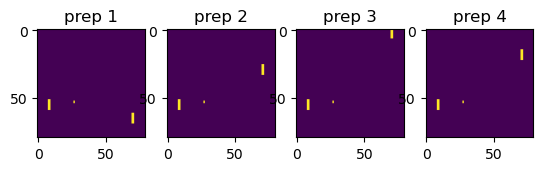

In [7]:
envs = gym.make_vec('PongDeterministic-v4', num_envs=ENV_NUM, vectorization_mode="sync")
# SyncVectorEnv('PongDeterministic-v4', num_envs=2)
# envs = gym.vector.SyncVectorEnv([
#     lambda: gym.make('PongDeterministic-v4'),
#     lambda: gym.make('PongDeterministic-v4')
# ])
envs.reset()
_, _, _, _, _= envs.step([0]*ENV_NUM)
# get a frame after 20 steps - that's about the number needed to see the full screen with gameplay
for _ in range(20):
    frames, _, _, _, _ = envs.step(np.random.choice([2, 3], ENV_NUM))

processed_frames = batch_preprocess(frames)
print(processed_frames.shape) 

for i in range(ENV_NUM):
    plt.subplot(2,4,i+1)
    plt.imshow(processed_frames[i][0].cpu())
    plt.title(f'prep {i+1}')

plt.show()

In [8]:
# Create tensors, just experimenting
A = torch.tensor([[1], [2], [3], [4], [5], [6], [7], [8]])  # Shape (8, 1)
B = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8])  # Shape (8,)

# Broadcasting comparison
result = A == B  # Shape (8, 8)
print(result)
# Step 1: Mimic B broadcasting
B_expanded = B.unsqueeze(0).expand(8, -1)
B_expanded = B.unsqueeze(0).repeat(8, 1) # same code
print(B_expanded) # Add dim and expand to (8, 8)
# Step 2: Mimic A broadcasting
A_expanded = A.expand(-1,8)
A_expanded = A.repeat(1, 8) # same code 
print(A_expanded)

print(A_expanded == B_expanded)
print(A.squeeze(1) == B)
print(A == B.unsqueeze(1))

tensor([[ True, False, False, False, False, False, False, False],
        [False,  True, False, False, False, False, False, False],
        [False, False,  True, False, False, False, False, False],
        [False, False, False,  True, False, False, False, False],
        [False, False, False, False,  True, False, False, False],
        [False, False, False, False, False,  True, False, False],
        [False, False, False, False, False, False,  True, False],
        [False, False, False, False, False, False, False,  True]])
tensor([[1, 2, 3, 4, 5, 6, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6, 6

In [9]:
num_envs = envs.num_envs
obs, _ = envs.reset()

prev_processed_obs = batch_preprocess(obs)
UP = torch.tensor(2, dtype=torch.int8, device=DEVICE)
DOWN = torch.tensor(3,  dtype=torch.int8, device=DEVICE)

processed_obs = batch_preprocess(obs)
states = processed_obs - prev_processed_obs
prev_processed_obs = processed_obs
print(states.shape)
# calculate probability of taking action up
up_probs = model(states).squeeze(1)
print(up_probs.shape)
print(np.random.rand(num_envs).shape)

actions =  torch.where(torch.rand(num_envs, device=DEVICE) < up_probs, UP, DOWN)
print(actions.shape)
action_chosen_prob = torch.where(actions == UP,  up_probs,  (1 - up_probs))
print(action_chosen_prob)
obs, rewards, terminated, truncated, _ = envs.step(actions)


torch.Size([4, 1, 80, 80])
torch.Size([4])
(4,)
torch.Size([4])
tensor([0.4938, 0.5062, 0.4938, 0.5062], device='mps:0',
       grad_fn=<WhereBackward0>)


In [10]:
# List of 1000 tensors, each of size [8]
tensor_list = [torch.randn(8) for _ in range(1000)]

# Concatenate along a new dimension
result = torch.cat(tensor_list, dim=0)

print(result)  # Output: torch.Size([1000, 8])
print(torch.stack(tensor_list))

tensor([ 0.4605, -1.1000, -0.0170,  ...,  1.5477, -3.0894, -0.7864])
tensor([[ 0.4605, -1.1000, -0.0170,  ..., -0.9979, -1.2998, -1.2934],
        [ 0.3177, -0.5443, -1.6457,  ..., -0.1339,  1.0544,  0.4364],
        [-1.7258,  0.7043,  0.3870,  ..., -0.1748,  1.0794,  1.5406],
        ...,
        [-0.4806, -2.2868,  1.7577,  ...,  0.5256, -0.2457,  1.3513],
        [ 0.1553, -1.2612, -0.8923,  ...,  0.4001, -1.0494, -0.5598],
        [-0.9811, -0.2150, -1.1801,  ...,  1.5477, -3.0894, -0.7864]])


In [11]:
a = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=torch.float32)
print(a)
b = a.flip(dims=[0]).cumsum(dim=0).flip(dims=[0])
print(b)
mean = torch.mean(b, dim=1, keepdim=True)
print(mean)
std = torch.std(b, dim=1, keepdim=True) + 1.0e-10
print(std)
print(b - mean)
print(torch.mean(b))

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
tensor([[12., 15., 18.],
        [11., 13., 15.],
        [ 7.,  8.,  9.]])
tensor([[15.],
        [13.],
        [ 8.]])
tensor([[3.],
        [2.],
        [1.]])
tensor([[-3.,  0.,  3.],
        [-2.,  0.,  2.],
        [-1.,  0.,  1.]])
tensor(12.)


In [12]:
import torch 

a = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=torch.float32)
print(a)
b = a.flip(dims=[0]).cumsum(dim=0).flip(dims=[0])
print(b)
mean = torch.mean(b, dim=1, keepdim=True)
print(mean)
std = torch.std(b, dim=1, keepdim=True) + 1.0e-10
print(std)
print(b - mean)
mean = torch.mean(b, dim=0, keepdim=True)
print(mean)
std = torch.std(b, dim=0, keepdim=True) + 1.0e-10
print(std)
print(b-mean)
print((b-mean)/std)

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])
tensor([[12., 15., 18.],
        [11., 13., 15.],
        [ 7.,  8.,  9.]])
tensor([[15.],
        [13.],
        [ 8.]])
tensor([[3.],
        [2.],
        [1.]])
tensor([[-3.,  0.,  3.],
        [-2.,  0.,  2.],
        [-1.,  0.,  1.]])
tensor([[10., 12., 14.]])
tensor([[2.6458, 3.6056, 4.5826]])
tensor([[ 2.,  3.,  4.],
        [ 1.,  1.,  1.],
        [-3., -4., -5.]])
tensor([[ 0.7559,  0.8321,  0.8729],
        [ 0.3780,  0.2774,  0.2182],
        [-1.1339, -1.1094, -1.0911]])
